In [18]:
%pip install pytorch_lightning

In [19]:
import torch
from torch import nn
import torch.quantization
import pytorch_lightning as pl
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import pandas as pd
import numpy as np

In [20]:
import requests

url = "https://www.dropbox.com/scl/fi/x2eh2yil56rgu5id1fwbm/cnn_data1.csv?rlkey=7bltxkitlwdnuirw08r2ysuv4&st=nppxtfhe&dl=1"

response = requests.get(url)

# Save the file locally
with open('cnn_data1.csv', 'wb') as file:
    file.write(response.content)

In [21]:
csv_file_path = "cnn_data1.csv"  # Replace with the actual path to the produced CSV file

# Load the CSV into a DataFrame and assign it to the desired column names
df = pd.read_csv(csv_file_path)

df['Total_Activations_Batch_Size'] = df['Total Activations'] * df['Batch Size']
df.loc[df['Status'] == 'OOM_CRASH', 'Max GPU Memory (MiB)'] = 45000


print(df['Max GPU Memory (MiB)'])

print("#datapoints: ", len(df))


# dropping lines that they have NaN values as they will cause error in the next steps
# df = df.dropna()

df = df.dropna(subset=['Activation Function'])

df = df[~df['architecture'].isin(['residual', 'dense'])]


df = df[['Max GPU Memory (MiB)', 'Depth', 'Batch Size', 'Total Parameters', 'Total Activations', 'Activations-Params', 'Activation Function',
         'Total_Activations_Batch_Size','Conv2d Count', 'BatchNorm2d Count', 'Dropout Count',
         'Input Size (MB)', 'Forward/Backward Pass Size (MB)', 'Params Size (MB)',
         'Estimated Total Size (MB)']]

print(df.columns)

# Map the existing columns to your desired column structure
df = df.rename(columns={
    'Max GPU Memory (MiB)': 'real_memory_usage',
    'Depth': 'layers',
    'Batch Size': 'batch_size',
    'Total Parameters': 'all_parameters',
    'Total Activations': 'all_activations',
    'Activations-Params': 'params_activations_list'
})

# print(df)

print('max layers: ', df['layers'].max(), 'min: ', df['layers'].min())
print('max parameters: ', df['all_parameters'].max(), 'min: ', df['all_parameters'].min())
print('max activations: ', df['all_activations'].max(), 'min: ', df['all_activations'].min())
print('max batch_size: ', df['batch_size'].max(), 'min: ', df['batch_size'].min())
print('max gpumemory_max: ', df['real_memory_usage'].max(), 'min: ', df['real_memory_usage'].min())
print('len dataset: ', len(df), df.columns)

0       39517
1       45000
2        6293
3        6475
4        2779
        ...  
8995    45000
8996    45000
8997    26097
8998    45000
8999     4321
Name: Max GPU Memory (MiB), Length: 9000, dtype: int64
#datapoints:  9000
Index(['Max GPU Memory (MiB)', 'Depth', 'Batch Size', 'Total Parameters',
       'Total Activations', 'Activations-Params', 'Activation Function',
       'Total_Activations_Batch_Size', 'Conv2d Count', 'BatchNorm2d Count',
       'Dropout Count', 'Input Size (MB)', 'Forward/Backward Pass Size (MB)',
       'Params Size (MB)', 'Estimated Total Size (MB)'],
      dtype='object')
max layers:  119 min:  5
max parameters:  329307377 min:  704
max activations:  5317481490 min:  24514
max batch_size:  62 min:  2
max gpumemory_max:  45000 min:  1703
len dataset:  6516 Index(['real_memory_usage', 'layers', 'batch_size', 'all_parameters',
       'all_activations', 'params_activations_list', 'Activation Function',
       'Total_Activations_Batch_Size', 'Conv2d Count', 'Bat

In [22]:
# List of activation functions
activations = ['ELU', 'GELU', 'LeakyReLU', 'Mish', 'PReLU', 'ReLU', 'SELU', 'SiLU', 'Softplus', 'Tanh']

# Function to create positional encoding
def positional_encoding_2d(num_states):
    positions = []
    for i in range(num_states):
        position = (np.sin(i * np.pi / num_states), np.cos(i * np.pi / num_states))
        positions.append(position)
    return np.array(positions)

# Generate positional encodings
positional_encodings = positional_encoding_2d(len(activations))
activation_to_encoding = {activation: positional_encodings[i] for i, activation in enumerate(activations)}

# Apply positional encoding to 'activation_function' column
df['activation_encoding_sin'] = df['Activation Function'].map(lambda x: activation_to_encoding[x][0])
df['activation_encoding_cos'] = df['Activation Function'].map(lambda x: activation_to_encoding[x][1])

print(df.columns)

Index(['real_memory_usage', 'layers', 'batch_size', 'all_parameters',
       'all_activations', 'params_activations_list', 'Activation Function',
       'Total_Activations_Batch_Size', 'Conv2d Count', 'BatchNorm2d Count',
       'Dropout Count', 'Input Size (MB)', 'Forward/Backward Pass Size (MB)',
       'Params Size (MB)', 'Estimated Total Size (MB)',
       'activation_encoding_sin', 'activation_encoding_cos'],
      dtype='object')


In [23]:
import ast

# Reset the index to ensure it is in the default integer format
df = df.reset_index(drop=True)

max_layer = 0

# Check if the column 'params_activations_list' exists
if 'params_activations_list' in df.columns:
    for i in range(len(df)):
        try:
            # Check if the entry is already a list; if not, use ast.literal_eval to convert it
            entry = df['params_activations_list'].iloc[i]  # Use iloc to access the row by position

            if isinstance(entry, str):
                current_list = ast.literal_eval(entry)
            else:
                current_list = entry

            # Ensure the parsed content is a list
            if isinstance(current_list, list):
                l = len(current_list)
                if l > max_layer:
                    max_layer = l
            else:
                print(f"Unexpected format at index {i}: {entry}")

        except (ValueError, SyntaxError) as e:
            print(f"Error processing entry at index {i}: {entry} - {e}")

    print('Maximum layers:', max_layer)
else:
    print("Column 'params_activations_list' does not exist in the DataFrame.")


Maximum layers: 119


In [24]:
df

,real_memory_usage,layers,batch_size,all_parameters,all_activations,params_activations_list,Activation Function,Total_Activations_Batch_Size,Conv2d Count,BatchNorm2d Count,Dropout Count,Input Size (MB),Forward/Backward Pass Size (MB),Params Size (MB),Estimated Total Size (MB),activation_encoding_sin,activation_encoding_cos
0,39517,69,62,1864805,195826172,"[('conv2d', 183956976, 2744), ('GELU', 1839569...",GELU,12141222664,22,0,22,21.70,123506.48,7.11,123535.29,0.309017,9.510565e-01
1,45000,47,46,32924348,306385536,"[('conv2d', 44835280, 700), ('batchnorm2d', 44...",SELU,14093734656,11,11,11,2.30,134408.32,125.60,134536.22,0.951057,-3.090170e-01
2,6293,31,34,1730036,27443119,"[('conv2d', 33323400, 3388), ('ELU', 33323400,...",ELU,933066046,14,0,0,3.06,10678.04,6.60,10687.70,0.000000,1.000000e+00
3,6475,67,10,731920,119603463,"[('conv2d', 18688000, 2044), ('batchnorm2d', 1...",ELU,1196034630,16,16,16,2.90,11406.30,2.79,11411.99,0.000000,1.000000e+00
4,2779,39,18,2960902,11111315,"[('conv2d', 2230272, 640), ('batchnorm2d', 223...",ReLU,200003670,12,12,0,0.18,2034.54,11.29,2046.01,1.000000,6.123234e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6511,12765,79,8,69541327,261412634,"[('conv2d', 3951360, 1960), ('batchnorm2d', 39...",Tanh,2091301072,19,19,19,0.64,19944.16,265.28,20210.08,0.309017,-9.510565e-01
6512,45000,87,14,174087245,1224102531,"[('conv2d', 78314600, 9268), ('batchnorm2d', 7...",ELU,17137435434,21,21,21,2.66,163435.30,664.09,164102.05,0.000000,1.000000e+00
6513,45000,66,26,206115033,964897150,"[('conv2d', 179144784, 12152), ('ELU', 1791447...",ELU,25087325900,21,0,21,4.68,255201.44,786.27,255992.39,0.000000,1.000000e+00
6514,26097,90,22,250091310,273489723,"[('conv2d', 25423200, 8988), ('PReLU', 2542320...",PReLU,6016773906,29,0,29,0.88,61205.76,954.02,62160.66,0.951057,3.090170e-01


In [25]:
# bins = [i * 10000 for i in range(6)]
# # bins.append(float('inf'))

# # Define labels corresponding to the bins
# labels = [i for i in range(len(bins) - 1)]
bins = [0, 10000, 20000, 30000, 40000, 45000]
labels = [i for i in range(0, len(bins) - 1)]
print(bins, labels)
# Use pd.cut() to create a new column with labels based on the bins
df['memory_usage_label'] = pd.cut(df['real_memory_usage'], bins=bins, labels=labels, right=False)

# Display some rows where 'memory_usage_label' falls into the last bin (infinite)
inf_rows = df.loc[df['memory_usage_label'] == labels[2]]  # labels[-1] is the label for the last bin
print(inf_rows.head())

[0, 10000, 20000, 30000, 40000, 45000] [0, 1, 2, 3, 4]
    real_memory_usage  layers  batch_size  all_parameters  all_activations  \
6               23237      61          10       148861286        360667136   
31              22767      27          26        16999317        194275882   
35              22021      47          44        32209056         94644308   
36              29639      51          52        28593714        113001220   
49              20121      91          34        66560318        117515714   

                              params_activations_list Activation Function  \
6   [('conv2d', 11444400, 1100), ('Softplus', 1144...            Softplus   
31  [('conv2d', 45864000, 900), ('ELU', 45864000, ...                 ELU   
35  [('conv2d', 18311040, 900), ('batchnorm2d', 18...                Mish   
36  [('conv2d', 6443008, 448), ('batchnorm2d', 644...                Tanh   
49  [('conv2d', 2985472, 784), ('batchnorm2d', 298...                 ELU   

    Total_Act

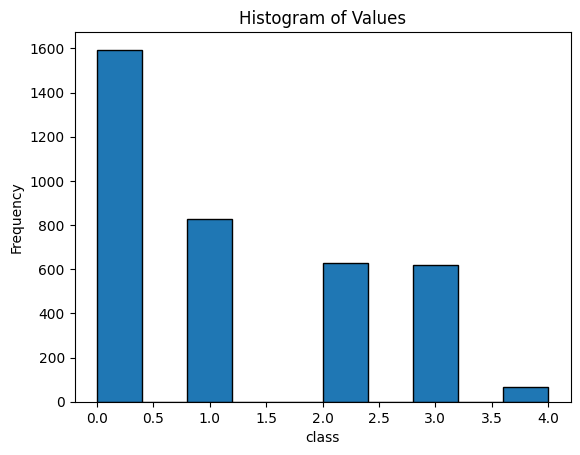

In [26]:
# Plot the histogram
import matplotlib.pyplot as plt

plt.hist(df['memory_usage_label'], bins=len(labels)*2, edgecolor='black')  # bins can be adjusted
plt.title('Histogram of Values')
plt.xlabel('class')
plt.ylabel('Frequency')
plt.show()

In [27]:
print(df.columns)
from sklearn.model_selection import train_test_split
x_train, x_temp, y_train, y_temp = train_test_split(
    df[['params_activations_list', 'batch_size', 'all_parameters', 'all_activations', 'Total_Activations_Batch_Size',
        'Conv2d Count', 'BatchNorm2d Count','Dropout Count',
        # 'Input Size (MB)', 'Forward/Backward Pass Size (MB)', 'Params Size (MB)', 'Estimated Total Size (MB)',
        'activation_encoding_sin', 'activation_encoding_cos',
       ]].values, df['memory_usage_label'].values, test_size=0.3, random_state=42)

x_test, x_val, y_test, y_val = train_test_split(
    x_temp, y_temp, test_size=0.66, random_state=42)

print('total data size: ', len(df))
print(f"train size {len(x_train)}, val size: {len(x_val)}, test size: {len(x_test)}")

Index(['real_memory_usage', 'layers', 'batch_size', 'all_parameters',
       'all_activations', 'params_activations_list', 'Activation Function',
       'Total_Activations_Batch_Size', 'Conv2d Count', 'BatchNorm2d Count',
       'Dropout Count', 'Input Size (MB)', 'Forward/Backward Pass Size (MB)',
       'Params Size (MB)', 'Estimated Total Size (MB)',
       'activation_encoding_sin', 'activation_encoding_cos',
       'memory_usage_label'],
      dtype='object')
total data size:  6516
train size 4561, val size: 1291, test size: 664


# Dataloader CNN

In [29]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

def encode_layer_cnn(layer_type):
    if layer_type in ['adaptive_avg_pool2d', 'Sigmoid', 'softmax', 'ELU', 'GELU', 'Identity', 'LeakyReLU', 'Mish', 'PReLU', 'ReLU', 'SELU', 'SiLU', 'Softplus', 'Tanh']:
        return [1, 0]
    elif layer_type == 'conv2d':
        return [0, 1]
    elif layer_type == 'linear':
        return [1, 1]
    elif layer_type in ['dropout','batchnorm2d']:
        return [0, 0]
    else:
        print(layer_type)
        raise ValueError("Unknown layer type")

# Function to process each sequence
def process_sequence(sequence):
    processed_sequence = []
    for entry in eval(sequence):  # Evaluate string as list of tuples
        layer_type, feature_1, feature_2 = entry
        # for fc
        # encoded_layer = encode_layer(layer_type)
        # for cnn
        encoded_layer = encode_layer_cnn(layer_type)
        combined = encoded_layer + [feature_1, feature_2]
        processed_sequence.append(combined)
    return np.array(processed_sequence)

def get_filtered_lists(list1, list2, list3):
    filtered_list1, filtered_list2, filtered_list3 = zip(*[(l1, l2, l3) for l1, l2, l3 in zip(list1, list2, list3) if len(l1) > 0])
    return filtered_list1, filtered_list2, filtered_list3

# Dataset preparation
class LayerSequenceDataset(Dataset):
    def __init__(self, x_data, y_labels, max_seq_len):
        self.x_data = [process_sequence(seq[0]) for seq in x_data]
        self.batch_size = [np.array(seq[1:]).astype(np.int64) for seq in x_data]
        self.y_labels = y_labels
        self.x_data, self.batch_size, self.y_labels = get_filtered_lists(self.x_data, self.batch_size, self.y_labels)
        self.max_seq_len = max_seq_len

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        sequence = self.x_data[idx]
        batch_size = self.batch_size[idx]
        label = self.y_labels[idx]
        # Padding sequences to max length
        if len(sequence) < self.max_seq_len:
            padded_sequence = np.pad(sequence, ((0, self.max_seq_len - len(sequence)), (0,0)), 'constant')
        else:
            padded_sequence = sequence[:self.max_seq_len]


        return torch.tensor(padded_sequence, dtype=torch.float32), torch.tensor(label, dtype=torch.long), torch.tensor(batch_size, dtype=torch.float32)



# Example Usage
max_seq_len = max_layer  # Set the max sequence length based on your data
x_train = np.array(x_train)  # Your input sequences here
y_train = np.array(y_train)  # Your labels here

# Initialize dataset and dataloader
train_dataset = LayerSequenceDataset(x_train, y_train, max_seq_len)
train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True)

val_dataset = LayerSequenceDataset(x_val, y_val, max_seq_len)
val_dataloader = DataLoader(val_dataset, batch_size=512, shuffle=False)

test_dataset = LayerSequenceDataset(x_test, y_test, max_seq_len)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

inputs, label_sample, batch_sample = next(iter(train_dataloader))
print(inputs.shape, label_sample.shape, batch_sample.shape)


RuntimeError: value cannot be converted to type int64 without overflow

# dataloader with varied length

In [ ]:
# class LayerSequenceDataset_varied_length(Dataset):
#     def __init__(self, x_data, y_labels):
#         self.x_data = [process_sequence(seq[0]) for seq in x_data]
#         self.y_labels = y_labels

#     def __len__(self):
#         return len(self.x_data)

#     def __getitem__(self, idx):
#         sequence = self.x_data[idx]
#         label = self.y_labels[idx]
#         return torch.tensor(sequence, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

# # Custom collate function to dynamically pad sequences to the max length in the batch
# def collate_fn(batch):
#     sequences, labels = zip(*batch)

#     # Find the maximum sequence length in the current batch
#     max_len = max([seq.size(0) for seq in sequences])

#     # Pad all sequences in the batch to the max sequence length
#     padded_sequences = [torch.nn.functional.pad(seq, (0, 0, 0, max_len - seq.size(0)), 'constant', 0) for seq in sequences]

#     # Stack the sequences and labels into tensors
#     padded_sequences = torch.stack(padded_sequences)
#     labels = torch.stack(labels)

#     return padded_sequences, labels

# train_dataset = LayerSequenceDataset_varied_length(x_train, y_train)
# train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

# val_dataset = LayerSequenceDataset_varied_length(x_val, y_val)
# val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

# test_dataset = LayerSequenceDataset_varied_length(x_test, y_test)
# test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

# inputs, labels = next(iter(train_dataloader))
# print(inputs.shape, labels.shape)


# model

In [ ]:
from pytorch_lightning import seed_everything

seed = 11  # Set your desired seed
seed_everything(seed, workers=True)
torch.use_deterministic_algorithms(False)


In [ ]:
import torch.optim as optim

class TransformerClassifier(nn.Module):
    def __init__(self, num_features, num_classes, d_model, nhead, num_layers, dim_feedforward, dropout, max_seq_len):
        super(TransformerClassifier, self).__init__()
        self.d_model = d_model
        self.embedding = nn.Sequential(nn.Linear(num_features, d_model),  # Embedding layer for input features
                                        # nn.LayerNorm(d_model),
                                       nn.BatchNorm1d(max_seq_len),
                                       nn.ReLU(),
                                       nn.Linear(d_model, d_model),
                                       nn.BatchNorm1d(max_seq_len),
                                       nn.ReLU(),
                                       )
        # Positional Encoding
        self.positional_encoding = nn.Parameter(self._get_positional_encoding(max_seq_len, d_model), requires_grad=False)

        # Transformer layers
        transformer_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout
        )
        self.transformer_encoder = nn.TransformerEncoder(transformer_layer, num_layers=num_layers)

        # Final classification layer
        self.fc_out = nn.Sequential(nn.Linear(d_model+9, d_model),
                                    nn.BatchNorm1d(d_model),
                                    nn.ReLU(),
                                    nn.Linear(d_model, num_classes),
        )

    def _get_positional_encoding(self, max_seq_len, d_model):
        pos_encoding = torch.zeros(max_seq_len, d_model)
        positions = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))

        pos_encoding[:, 0::2] = torch.sin(positions * div_term)
        pos_encoding[:, 1::2] = torch.cos(positions * div_term)

        return pos_encoding.unsqueeze(0)

    def forward(self, x, batch_size_feature):
        # Add positional encoding
        seq_len = x.size(1)
        x = self.embedding(x) + self.positional_encoding[:, :seq_len, :]

        # Transformer encoder
        x = self.transformer_encoder(x)

        # Classification (average pooling over sequence dimension)
        x = x.sum(dim=1)  # Pool over the sequence dimension

        # Ensure batch_size_feature has the correct shape
        batch_size_feature = batch_size_feature.unsqueeze(1) if batch_size_feature.dim() == 1 else batch_size_feature

        # batch_size_feature=batch_size_feature.unsqueeze(1)
        x = torch.cat((x, batch_size_feature), dim=1)

        # Output layer for classification
        output = self.fc_out(x)

        return output

In [ ]:
class classification_gpu_usage(pl.LightningModule):
    def __init__(self, output_size):
        super(classification_gpu_usage, self).__init__()
        # Define your model
        self.model = TransformerClassifier(num_features=4, num_classes=len(labels), d_model=6, nhead=3,
                                           num_layers=3, dim_feedforward=8, dropout=0, max_seq_len=max_layer)
        self.criterion = nn.CrossEntropyLoss()
        # self.criterion = nn.BCEWithLogitsLoss()

    def forward(self, x, b):
        return self.model(x, b)

    def training_step(self, batch, batch_idx):
        x, y, b = batch[0], batch[1], batch[2]
        y = y.long()
        logits = self.forward(x, b)
        loss = self.criterion(logits, y)
        self.log('train_loss', loss, on_epoch=True, on_step=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y, b = batch[0], batch[1], batch[2]
        y = y.long()
        logits = self.forward(x, b)
        loss = self.criterion(logits, y)
        self.log('val_loss', loss, prog_bar=True, on_epoch=True, on_step=True)
        return loss

    def configure_optimizers(self):
        # Create a quantized optimizer
        optimizer = optim.AdamW(self.parameters(), lr=0.001)

        return optimizer

    # def configure_optimizers(self):
    #     optimizer = Adam(self.parameters(), lr=0.001)

    #     # Use a scheduler that doesn't require setting the learning rate explicitly
    #     scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
    #     return {
    #         'optimizer': optimizer,
    #         'lr_scheduler': {
    #             'scheduler': scheduler,
    #             'monitor': 'val_loss',
    #             'frequency': 1
    #         }
    #     }

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=True, mode='min')
classifier_model = classification_gpu_usage(output_size = len(labels))
classifier_model.train()



In [ ]:
trainer = pl.Trainer(
    max_epochs=600,  # you can set this higher, early stopping will halt training
    callbacks=[early_stopping],
    # precision='16-mixed',  # Use AMP
    # accelerator='gpu',  # Use GPU if available
    # devices=1  # Number of GPUs
)

# Train the model
trainer.fit(classifier_model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

In [ ]:
classifier_model.eval()
pred_list, gt = list(), list()
with torch.no_grad():
    for test_data in test_dataloader:
        pred = classifier_model(test_data[0],test_data[2])
        # print(f"prediction: {torch.argmax(pred, 1)}, ground truth: {test_data[1]}")
        gt.append(test_data[1].item())
        pred_list.append(torch.argmax(pred, 1).item())

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

def calculate_metrics(gt, preds):
    # Calculate the various metrics
    accuracy = accuracy_score(gt, preds)
    precision = precision_score(gt, preds, average='weighted')  # Use 'weighted' to handle class imbalance
    recall = recall_score(gt, preds, average='weighted')
    f1 = f1_score(gt, preds, average='weighted')
    cm = confusion_matrix(gt, preds)

    # Print the results
    print("Accuracy: {:.4f}".format(accuracy))
    print("Precision: {:.4f}".format(precision))
    print("Recall: {:.4f}".format(recall))
    print("F1-Score: {:.4f}".format(f1))
    print("\nConfusion Matrix:")
    print(cm)

    # Full classification report
    print("\nClassification Report:")
    print(classification_report(gt, preds))

calculate_metrics(gt, pred_list)
